# Exercise: Train a U-Net for semantic segmentation in Nautilus


## <span style='color:green'>Before you get started, ensure you have successfully complete the Practice!</span>


In [1]:
import os
import sys

from jinja2 import Template
import yaml

# Generate yml file for jobs

Instead of maually creating multiple yml files that vary very little from each other, we can exploit this advantage by generating them automatically

In [2]:
template ='''
apiVersion: batch/v1
kind: Job
metadata:
  name: job-unet-train-{{sso}}-{{fold}}
spec:
  template:
    spec:
      automountServiceAccountToken: false
      containers:
      - name: pod-unet-train-{{sso}}-{{fold}}
        image: gitlab-registry.nrp-nautilus.io/aomqc/umc_dsa_8430_sp2022_image:latest
        workingDir: /{{persistentVolume_name}}
        command: ["/bin/sh","-c"]
        args: ["python3 U_Net_training.py {{ fold }} {{ epochs }}; python3 U_Net_prediction.py {{ fold }}; python3 U_Net_evaluation.py {{ fold }} "]
        volumeMounts:
        - name: {{persistentVolume_name}}
          mountPath: /{{persistentVolume_name}}
        resources:
            limits:
              memory: 20Gi
              cpu: 1
              nvidia.com/gpu: 1
            requests:
              memory: 20Gi
              cpu: 1
              nvidia.com/gpu: 1
      volumes:
      - name: {{persistentVolume_name}} 
        persistentVolumeClaim:
            claimName: {{persistentVolume_name}}
      restartPolicy: OnFailure      
  backoffLimit: 


'''

In [3]:
j2_template = Template(template)

# Fill the variables below with the appropriate information

In [4]:
sso = 'lcmhng' # as string
persistentVolume_name = 'lcmhng-pv' # as string
epochs = 50 # you can choose a different value if you wish

In [5]:
for fold in list(range(5)):
    data = {'fold':fold,'sso':sso,'persistentVolume_name':persistentVolume_name,'epochs':epochs}
    output_file = j2_template.render(data)
    fileout = open('job-U_Net_training-{}-{}.yml'.format(sso,fold),'w')
    fileout.write(output_file)
    fileout.close()

### Before you continue, verify that you have created the 5 YAML files.

![Kubernetes_Exercise_CreatedYAML_FromTemplate.png MISSING](../images/Kubernetes_Exercise_CreatedYAML_FromTemplate.png)


#### If so, take a moment to add these YAML files into your submission using git; create a specific commit for the _M5 Exercise YAML files_

---
# Submit jobs for training


You will have to submit each job manually, so you will have to do it 5 times since we have 5 folds.   
Note, the below command is an example, where `{sso}` would be replaced with your actual SSO id, as you entered for the variable above.

```BASH
kubectl create -f job-U_Net_training-{sso}-{fold}.yml
```


You can monitor the progress of your training by checking on your pods  
```BASH
kubectl get pods
```


Eventually, your pods should all be completed!

```BASH
jovyan@jupyter-scottgs-40missouri-2eedu:~/ParallelProgrammingAnalytics/module5/exercises$ kubectl get pods
NAME                                READY   STATUS      RESTARTS   AGE
job-unet-train-scottgs-0--1-zqs8w   0/1     Completed   0          9m15s
job-unet-train-scottgs-1--1-vlpxz   0/1     Completed   0          16m
job-unet-train-scottgs-2--1-q9c4s   0/1     Completed   0          9m12s
job-unet-train-scottgs-3--1-kmngw   0/1     Completed   0          9m8s
job-unet-train-scottgs-4--1-n659m   0/1     Completed   0          9m5s
```


### If not all your jobs complete successfully, you may need to resubmit it!

Connecting to your PVC, you can check for the existance of the expected output files.

When you have all your evaluation files, you are good to proceed.

```BASH
root@pod-scottgs:/data# find evaluation/ | sort
evaluation/
evaluation/eval_results_train0.csv
evaluation/eval_results_train1.csv
evaluation/eval_results_train2.csv
evaluation/eval_results_train3.csv
evaluation/eval_results_train4.csv
evaluation/eval_results_validation0.csv
evaluation/eval_results_validation1.csv
evaluation/eval_results_validation2.csv
evaluation/eval_results_validation3.csv
evaluation/eval_results_validation4.csv
```


----

# Training curves

The folder **logs** contains 5 csv files, one for each fold training. Use those files for the next two sections

Please consult the Lab to copy the files from the persistent storage to your local Jupyter Environment.

## Plotting training curves for each fold


Plot the four paramters for each training fold in a single figure.
You will create four images, filename pattern `parameters_fold{N}.png` where {N} is 0, 1, 2, 3, 4

![Your parameters from fold5 is MISSING](parameters_fold0.png)

![Your parameters from fold1 is MISSING](parameters_fold1.png)

![Your parameters from fold2 is MISSING](parameters_fold2.png)

![Your parameters from fold3 is MISSING](parameters_fold3.png)

![Your parameters from fold4 is MISSING](parameters_fold4.png)



### In the cell below, write the code to load your log files, explore them, and then generate the images.

Add additional Code cells if necessary!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
# Add code for generating images here
train0 = pd.read_csv('training0.csv')
train1 = pd.read_csv('training1.csv')
train2 = pd.read_csv('training2.csv')
train3 = pd.read_csv('training3.csv')
train4 = pd.read_csv('training4.csv')

train_list = [train0,
              train1,
              train2,
              train3,
              train4]
x = 0

for item in train_list:
    
    plt.plot(item.epoch, item.accuracy, label='train accuracy')
    plt.plot(item.loss, color='red', label='train loss')
    plt.plot(item.val_accuracy, color='green', label='val accuracy')
    plt.plot(item.val_loss, color='darkviolet', label = 'val loss')
    
    plt.title(f'parameters_fold{x}')
    plt.legend(loc='lower right')
    
    plt.savefig(f'parameters_fold{x}.png')
    x += 1
    plt.clf()


<Figure size 432x288 with 0 Axes>

---

## Plot each of the four learning parameters across the 5 folds 

Plot each of the four learning paramters (training accuracy, training loss, validation accuracy, validation loss) across the 5 folds. 
Make sure that each graph has a title, and legend that shows each fold with different color.
For instance, your `train_acc.png` image will have 5 lines of the training accuracy, one per fold.

![Your train_acc.png is MISSING](train_acc.png) 

![Your train_loss.png is MISSING](train_loss.png)

![Your validation_acc.png is MISSING](validation_acc.png)

![Your validation_loss.png is MISSING](validation_loss.png)

### In the cell below, write the code to load your log files, explore them, and then generate the images.

Add additional Code cells if necessary!

In [34]:
# Add code for generating images here

# train accuracy

plt.plot(train0.accuracy, label='fold0')
plt.plot(train1.accuracy, color='red', label='fold1')
plt.plot(train2.accuracy, color='green', label='fold2')
plt.plot(train3.accuracy, color='darkviolet',label='fold3')
plt.plot(train4.accuracy, color='gray', label='fold4')

plt.title('Train Accuracy')
plt.legend(loc='lower right')

plt.savefig('train_acc.png')

plt.clf()

# train loss

plt.plot(train0.loss, label='fold0')
plt.plot(train1.loss, color='red', label='fold1')
plt.plot(train2.loss, color='green', label='fold2')
plt.plot(train3.loss, color='darkviolet',label='fold3')
plt.plot(train4.loss, color='gray', label='fold4')

plt.title('Train Loss')
plt.legend(loc='lower right')

plt.savefig('train_loss.png')

plt.clf()

# val accuracy

plt.plot(train0.val_accuracy, label='fold0')
plt.plot(train1.val_accuracy, color='red', label='fold1')
plt.plot(train2.val_accuracy, color='green', label='fold2')
plt.plot(train3.val_accuracy, color='darkviolet',label='fold3')
plt.plot(train4.val_accuracy, color='gray', label='fold4')

plt.title('Validation Accuracy')
plt.legend(loc='lower right')

plt.savefig('validation_acc.png')

plt.clf()

# val loss

plt.plot(train0.val_loss, label='fold0')
plt.plot(train1.val_loss, color='red', label='fold1')
plt.plot(train2.val_loss, color='green', label='fold2')
plt.plot(train3.val_loss, color='darkviolet',label='fold3')
plt.plot(train4.val_loss, color='gray', label='fold4')

plt.title('Validation Loss')
plt.legend(loc='lower right')

plt.savefig('validation_loss.png')

plt.clf()


<Figure size 432x288 with 0 Axes>

---

## Questions:

### 1. Examine all graphs and show which fold seems to have the best performance and which has the worst. 
### Give a short explanation for your choice

### 2. If you can change one parameter to improve the training, which one would it be and why

# Evaluation parameters

Use files in folder **evaluation** for the next section and questions that follows

The training graph can only tell you so much about how well trained your network is, 
we need to use the trained model to perform prediction and evaluate the results we get.    

For semantic segmentation we look at the following parameters:
* Accuracy  
* Recall    
* Precision  
* F1 score  
* IoU  


In the evaluation folder there are `csv` files for each fold for both train data and validation data. 
Each file lists the evaluation parameters for each image.

In [5]:
#Importing each file

er_train0 = pd.read_csv('eval_results_train0.csv')
er_train1 = pd.read_csv('eval_results_train1.csv')
er_train2 = pd.read_csv('eval_results_train2.csv')
er_train3 = pd.read_csv('eval_results_train3.csv')
er_train4 = pd.read_csv('eval_results_train4.csv')
er_val0 = pd.read_csv('eval_results_validation0.csv')
er_val1 = pd.read_csv('eval_results_validation1.csv')
er_val2 = pd.read_csv('eval_results_validation2.csv')
er_val3 = pd.read_csv('eval_results_validation3.csv')
er_val4 = pd.read_csv('eval_results_validation4.csv')

er_train_results = [er_train0, er_train1, er_train2, er_train3, er_train4]
er_val_results = [er_val0, er_val1, er_val2, er_val3, er_val4]

## Questions:

### 3. Compute the average of each paramter in each folder and list them below, does your answer from question 1 still stand?

Do this using code in the cell below.

## Answer

Based on the results I get from the below print out, I still believe fold4 to be the best performing model. Both the accuracy (though still low) sits at a good spot, and the F1 though still very low is the highest of all the validation folds. It also sits as one of the highest in the training set, but when comparing both train and validation together I believe the average holds better to suggest fold4

In [20]:
# Add your answer in this cell

print(f"Train Results\n\n")
x = 0

for r in er_train_results:
    print(f"Train Results {x}")
    for c in r.columns:
        if c == "Unnamed: 0":
            continue
        print(f"{c} : {str(r[c].mean())}")
    x += 1
    print("\n")

print(f"Validation Results\n\n")
x = 0

for r in er_val_results:
    print(f"Validation Results {x}")
    for c in r.columns:
        if c == "Unnamed: 0":
            continue
        print(f"{c} : {str(r[c].mean())}")
    x += 1
    print("\n")


Train Results


Train Results 0
accuracy : 0.7611647337278107
recall : 0.9999941836718234
precision : 0.761167299018222
F1 : 0.8614794754812749
IOU : 1.1667321546229911e-05


Train Results 1
accuracy : 0.7715677071005914
recall : 0.9999971689041415
precision : 0.7715693143262194
F1 : 0.8681817284833231
IOU : 2.1917558136516322e-06


Train Results 2
accuracy : 0.7732116124260353
recall : 0.9999845762486368
precision : 0.7732254752786745
F1 : 0.8685215127546335
IOU : 1.693795034320709e-06


Train Results 3
accuracy : 0.7682672928994085
recall : 0.9996166537277617
precision : 0.7684879183730593
F1 : 0.8655031507445642
IOU : 0.0008319932263616941


Train Results 4
accuracy : 0.7691363017751478
recall : 0.9998432344497807
precision : 0.7692494736156797
F1 : 0.8661168494318898
IOU : 0.00015279017113812562


Validation Results


Validation Results 0
accuracy : 0.20089005917159758
recall : 3.9601663825496006e-05
precision : 0.42609618461484944
F1 : 7.915525037157876e-05
IOU : 0.200868091650885

### 4. Compute the average of each of the evaluation parameters across the 5-folds. How does the average value comapre to the 5 vlaues for each parameter. 

## Answer

The averages I believe highlight the difference even more between the train and validation datasets. In the training versions we see a model we would assume would be good, but when comparing to the new scores in validation that becomes a different conversation. However, the averages when compared to fold4 still seem to suggest that particular fold is a better performer, though maybe not as much of a run-away leader as I would have thought based on the metrics above. 

In [36]:
# Add your answer in this cell

import statistics as stat

print("Training Stats\n")

train_acc_ave = []
for r in er_train_results:
    train_acc_ave.append(r.accuracy.mean())
print(f"Average Training Accuracy: {stat.mean(train_acc_ave)}")

train_rec_ave = []
for r in er_train_results:
    train_rec_ave.append(r.recall.mean())
print(f"Average Training Recall: {stat.mean(train_rec_ave)}")

train_prec_ave = []
for r in er_train_results:
    train_prec_ave.append(r.precision.mean())
print(f"Average Training Precision: {stat.mean(train_prec_ave)}")

train_f1_ave = []
for r in er_train_results:
    train_f1_ave.append(r.F1.mean())
print(f"Average Training F1: {stat.mean(train_f1_ave)}")

train_iou_ave = []
for r in er_train_results:
    train_iou_ave.append(r.IOU.mean())
print(f"Average Training IOU: {stat.mean(train_iou_ave)}")

## Validation Stats ---------------------------------------------------------------

print("\n\nValidation Stats\n")

val_acc_ave = []
for r in er_val_results:
    val_acc_ave.append(r.accuracy.mean())
print(f"Average Validation Accuracy: {stat.mean(val_acc_ave)}")

val_rec_ave = []
for r in er_val_results:
    val_rec_ave.append(r.recall.mean())
print(f"Average Validation Recall: {stat.mean(val_rec_ave)}")

val_prec_ave = []
for r in er_val_results:
    val_prec_ave.append(r.precision.mean())
print(f"Average Validation Precision: {stat.mean(val_prec_ave)}")

val_f1_ave = []
for r in er_val_results:
    val_f1_ave.append(r.F1.mean())
print(f"Average Validation F1: {stat.mean(val_f1_ave)}")

val_iou_ave = []
for r in er_val_results:
    val_iou_ave.append(r.IOU.mean())
print(f"Average Validation IOU: {stat.mean(val_iou_ave)}")


Training Stats

Average Training Accuracy: 0.7686695295857987
Average Training Recall: 0.9998871634004288
Average Training Precision: 0.768739896122371
Average Training F1: 0.8659605433791371
Average Training IOU: 0.00020006725397880439


Validation Stats

Average Validation Accuracy: 0.22972041420118341
Average Validation Recall: 0.00018895148809201936
Average Validation Precision: 0.2376463034738081
Average Validation F1: 0.00036761788844968116
Average Validation IOU: 0.22961161965091947


### 5. plot Precision Recall curve and compute the area under the curve, does your answer form the question1 still stands

## Answer

When reviewing the below I think my answer changes to a close race between fold0 and fold2. These 2 show a trend for a much better precision x recall score as they don't drop down nearing to 0 when values are sorted. I believe now looking at the below and then reviewing above again based on the below charts that I would lean finally toward fold2. Though precision x recall is all over the place, it tays higher overall and when comparing the validation accuracy from above it actually had the highest accurcay score at 0.25, which is above the average across all the folds. 

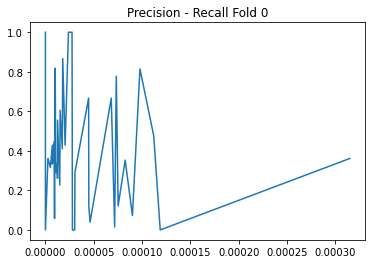

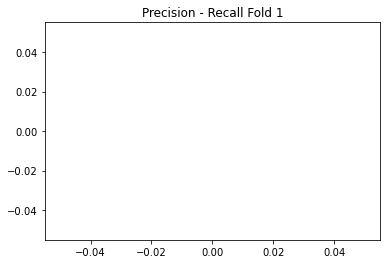

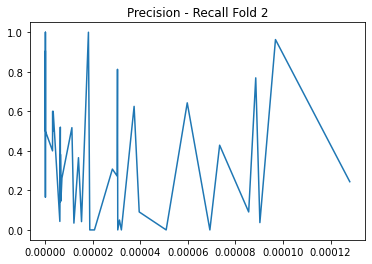

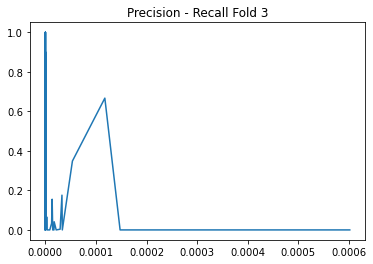

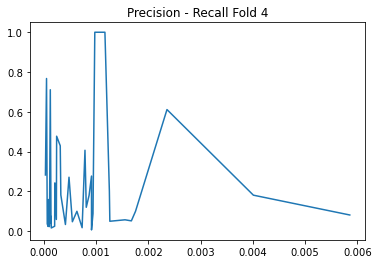

In [30]:
# Add your answer in this cell
x = 0

for r in er_val_results:
    plt.plot(r.recall.sort_values(), r.precision)
    plt.title(f'Precision - Recall Fold {x}')
    
    plt.show()
    
    x += 1

### 6. Select the image with the best F1 score from your validation set (any of the 5) and visualize the input image, the truth label and your predicted label  

In [13]:
# Getting image index/names

val_results = pd.read_csv('eval_results_validation2.csv')

val_results.sort_values(by='F1', ascending=False).head()

,Unnamed: 0,accuracy,recall,precision,F1,IOU
15,15,0.316256,0.000128,0.262411,0.000256,0.316196
1,1,0.266433,0.000097,0.165746,0.000194,0.266381
38,38,0.318350,0.000090,0.962963,0.000181,0.318308
0,0,0.251441,0.000089,0.903226,0.000177,0.251392
25,25,0.280764,0.000086,0.812500,0.000171,0.280720


Based on above I will use image 16 (due to 0 index) in the actual list to print out.

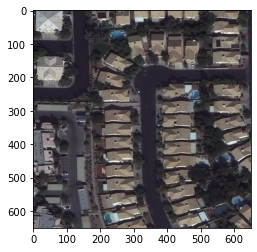

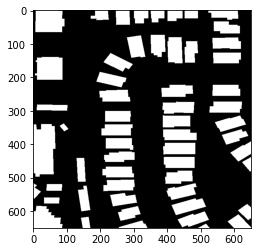

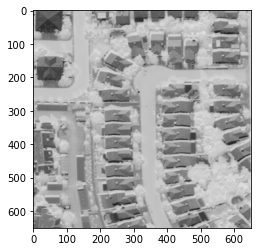

In [21]:
# Add your answer in this cell

img_array = [np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/images/RGB-PanSharpen_AOI_2_Vegas_img1156_img.npy'),
            np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/labels/RGB-PanSharpen_AOI_2_Vegas_img1156_lab.npy'),
            np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/predictions/fold_2/validation//RGB-PanSharpen_AOI_2_Vegas_img1156_img.npy')]
plt.imshow(img_array[0], cmap='gray')
plt.show()
plt.imshow(img_array[1], cmap='gray')
plt.show()
plt.imshow(img_array[2], cmap='gray')
plt.show()



### 7. Select the worst with the best F1 score from your validation set (any of the 5) and visualize the input image, the truth label and your predicted label  

In [14]:
val_results.sort_values(by='F1', ascending=True).head()

,Unnamed: 0,accuracy,recall,precision,F1,IOU
26,26,0.044080,0.0,0.0,0.0,0.044080
22,22,0.066002,0.0,0.0,0.0,0.066002
21,21,0.215830,0.0,0.0,0.0,0.215830
28,28,0.263882,0.0,0.0,0.0,0.263882
31,31,0.234630,0.0,0.0,0.0,0.234630


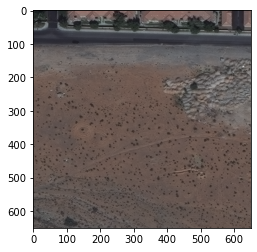

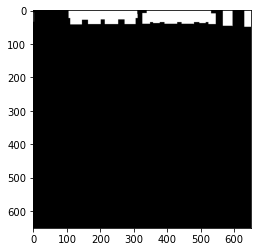

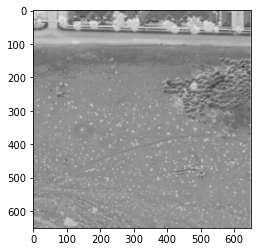

In [22]:
# Add your answer in this cell
img_array = [np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/images/RGB-PanSharpen_AOI_2_Vegas_img1173_img.npy'),
            np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/labels/RGB-PanSharpen_AOI_2_Vegas_img1173_lab.npy'),
            np.load('/home/jovyan/home/jovyan/s22dsa8430_lcmhng/module5/data/predictions/fold_2/validation/RGB-PanSharpen_AOI_2_Vegas_img1173_img.npy')]
plt.imshow(img_array[0], cmap='gray')
plt.show()
plt.imshow(img_array[1], cmap='gray')
plt.show()
plt.imshow(img_array[2], cmap='gray')
plt.show()





# Save your Notebook, add and commit all the Artifacts, and push your work!